# <span style='color:#15317E'>03 Capstone Project EDA and Models</span>

In [1]:
######
#### Author: Byron Stuart
#### Data Science Immersive Capstone Project
#### Date 06 June 2017
######

## <span style='color:#7D6115'>Capstone Project Navigation</span>
<a href='./01%20capstone_setup.ipynb'>Step 1 - Capstone Setup Notebook</a><br>
<a href='./02%20capstone_indicators.ipynb'>Step 2 - Capstone Indicator Notebook</a><br>
Step 3 - Capstone Project EDA and Models<br>
<a href='./04%20capstone_report.ipynb'>Step 4 - Capstone Report Notebook</a>

## <span style='color:#7D6115'>Capstone Project EDA</span>
For the initial project setup, EDA, SQL database and analysis, see the capstone setup notebook. All the data needed by this notebook is read in from the SQL database.

### Imports
Import widely used packages and setup dataframes from the SQL database.

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns

# for standardising predictors
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso, LinearRegression, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn import neighbors
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Import Sqlite3 Library
import sqlite3
#The SQL Sub-library from Pandas will allow us to run SQL queries within python.
from pandas.io import sql

# Establishing the Connection to our Database.  If no database exists here, this will create one.
connection = sqlite3.connect('../input/data.db.sqlite')

# define function to use when querying the sql database
def Q(query, db=connection):
    return sql.read_sql(query, db)

data = pd.DataFrame(Q('select * from world_health'))

world_data = pd.DataFrame(Q('select * from world_health_world'))
income_data = pd.DataFrame(Q('select * from world_health_income'))
combos_data = pd.DataFrame(Q('select * from world_health_combos'))
single_data = pd.DataFrame(Q('select * from world_health_single'))

indicators_df = pd.DataFrame(Q('select * from world_health_indicators'))

C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Retrieve all the indicators from the database

In [3]:
life_expectancy = list(pd.read_csv('./life_expectancy_df.csv').indicator)

indicators = data['Indicator Name'].unique()

income_indicators = list(indicators_df[indicators_df.name=='income'].indicator)
#combos_indicators = list(indicators_df[indicators_df.name=='combos'].indicator)
combos_indicators = list(pd.read_csv('./combos_indicators_df.csv').indicator)
single_indicators = list(indicators_df[indicators_df.name=='single'].indicator)

### Show number of indicators that will be used

In [4]:
print("Number of indicators:", len(combos_indicators), "\n")
for ind in combos_indicators:
    print(ind)

Number of indicators: 217 

health expenditure per capita, ppp
school enrollment, secondary, male (% gross)
malnutrition prevalence, weight for age, male (% of children under 5)
age population, age 23, male, interpolated
net migration
age population, age 03, male, interpolated
immunization, hepb3 (% of one-year-old children)
age population, age 04, male, interpolated
prevalence of anemia among women of reproductive age (% of women ages 15-49)
wanted fertility rate (births per woman)
age population, age 12, female, interpolated
age population, age 02, female, interpolated
children (ages 0-14) newly infected with hiv
pregnant women receiving prenatal care (%)
improved water source, rural (% of rural population with access)
incidence of hiv (% of uninfected population ages 15-49)
prevalence of overweight (% of children under 5)
sex ratio at birth (male births per female births)
smoking prevalence, males (% of adults)
age population, age 0, male, interpolated
population growth (annual %)
a

### Define year columns

In [5]:
year_columns = list(data.columns[4:])

### Function to return data by any combination of countries, indicators and years

In [6]:
# function to return data by any combination of countries, indicators and years
def data_countries_indicators_years(countries=[], indicators=[], years=[]):
    #print(countries, indicators, years)

    # create empty dataframe
    return_data = pd.DataFrame()
    if (len(countries) == 0):
        #print("All countries")
        return_data = data
    else:
        mask = data['Country Name'].isin(countries)
        return_data = data[mask]
        #print(type(return_data), return_data.shape)

    if (len(indicators) == 0):
       #print("All indicators")
        pass
    else:
        mask = return_data['Indicator Name'].isin(indicators)
        return_data = return_data[mask]
        #print(type(return_data), return_data.shape)
        
    columns = ['Country Name', 'Indicator Name', 'Indicator Code']   
    if (len(years) == 0):
        #print("All years")
        for year in year_columns:
            columns.append(year)
        return_data = return_data[columns]
    else:
        return_data = return_data[columns + years]

    return return_data

### Function to calculate median
numpy.median is failing to calculate a value if there's any nulls, this function works for most but not all data sets!?!

In [7]:
# example -> median = np.median(test_data[col]) # median is not replacing all the missing values for some datasets!
def median_calc(l):
    half = len(l) // 2
    l.sort()
    if not len(l) % 2:
        return (l[half - 1] + l[half]) / 2.0
    return l[half]

## <span style='color:#7D6115'>Data Cleaning and Setup</span>
This section will remove null values, set a target feature (y), construct a set of predictor features (X) and standardise the X values.

As the original data comes in a long format it is also necessary to transpose the dataframe so that the rows contain the yearly data and the columns are the X values.

### Set y target and X predictors
The target feature selected is 'life expectancy at birth, total (years)'. All features that have sufficient data have been selected to test for correlation. The data from all geographic country groupings plus 3 special disadvantaged groupings will be used for this.

In [8]:
# Target y, assign data to it later
y_indicator = 'life expectancy at birth, total (years)'

### Function to setup data for use by Tableau

In [9]:
def setup_tableau_data(combos, year_index, y, X, col_names):
    columns = ['Combo', 'Year'] + [y_indicator] + list(col_names)
    tableau_df = pd.DataFrame(columns=columns)
    for i in range(0, len(y)):
        #print([combos] + [year_index[i]] + [y[i]] + list(X[i]))
        tableau_df.loc[tableau_df.shape[0]] = [combos] + [year_index[i]] + [y[i]] + list(X[i])

    return tableau_df

### Function to do data cleaning of nulls and return y and standardised X <a name='cleaning_and_standardised' />

In [10]:
def data_process_nulls(combos, combos_indicators, use_median=True, tableau=True):
    # This will be the data for the X values
    test_data = data_countries_indicators_years([combos], combos_indicators)
    print("test_data.shape initial:", test_data.shape)

    ### Remove unnecessary features and transpose the dataframe
    column_names = [list(test_data['Indicator Name'])]
    test_data.drop(['Country Name'], axis=1, inplace=True)
    test_data.drop(['Indicator Name'], axis=1, inplace=True)
    test_data.drop(['Indicator Code'], axis=1, inplace=True)

    # invert X so that the predictors are columns and rename the columns
    test_data = test_data.T
    test_data.columns = column_names
    print('test_data.shape after removing unnecessary features and transpose', test_data.shape)

    ### Process missing values
    # If any columns have more than 20 nulls (>50%), drop them.
    #print("Columns with more than 20 nulls")
    cols_to_drop = []
    for col in test_data.columns:
        num_nulls = test_data[col].isnull().sum()
        if num_nulls > 20:
            #print(col, num_nulls)
            cols_to_drop.append(col)

    for col in cols_to_drop:
        test_data.drop([col], axis=1, inplace=True)
    print('test_data.shape after dropping columns with more than 20 nulls', test_data.shape)

    ### Process missing target values
    # For any y values that are null, drop the entire year.

    test_data = test_data[np.isnan(test_data[y_indicator])==False]

    # For use by any model that can process as a float
    y_as_float = test_data[y_indicator]

    # change y to an integer value for use in the other models
    test_data[y_indicator] = test_data[y_indicator].map(lambda x: int(x))
    y = test_data[y_indicator]

    ### Drop the life expectancy columns from the predictors
    # We have 'life expectancy' as the target so remove any columns related to it from the predictors

    #print(test_data.describe())
    for col in life_expectancy:
        test_data.drop([col], axis=1, inplace=True)
    print('test_data.shape after dropping life_expectancy and target nulls', test_data.shape)
    print()

    ### Replace remaining null values with the columns median
    for col in test_data.columns:
        if use_median:
            #replace = median_calc(list(test_data[col]))
            replace = test_data[col].median()
        else:
            replace = np.mean(test_data[col])

        #comment out this line if checking the number of null values remaining
        test_data[col].fillna(replace, inplace=True)

    tableau_df = None
    if tableau:
        tableau_df = setup_tableau_data(combos, test_data.index, y_as_float, test_data.values, test_data.columns)

    ### Standardise the predictors
    ss = StandardScaler()
    #comment out this line if checking the number of null values remaining
    X = ss.fit_transform(test_data)
    
    ### Plot the standardised values
    #fig_size_default = plt.rcParams["figure.figsize"]

    # do a box plot to check that the standardising has worked
    #plt.rcParams["figure.figsize"] = [16, 8]
    #pd.DataFrame(X).plot.box(rot=90)
    #plt.title('Standardised ' + combos + ' predictors')
    #plt.show()

    #plt.rcParams["figure.figsize"] = fig_size_default
    
    return y, y_as_float, X, test_data.columns, tableau_df

### Function to perform cross validation on the model and plot the predicted vs actual

In [11]:
def model_test(X_train, y_train, X_test, y_test, X, y, combos, name, model, summary_models):
    print('#' * 80)
    print(name + ' #' * 30)

    # fit the model to the training data
    model.fit(X_train, y_train)
    # cross validate the model with 5 folds except for these 2 exceptions
    if combos == 'Least developed countries: UN classification' or combos == 'South Asia':
        num_folds=3
    else:
        num_folds=5
    scores = cross_val_score(model, X, y, cv=num_folds)
    print(name + ' cross_val_score:', scores)
    print(name + ' cross_val_score mean:', np.mean(scores))
    # get the predictions and calculate R2
    predictions = cross_val_predict(model, X, y, cv=num_folds)
    
    r2 = metrics.r2_score(y, predictions)
    adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
    print("Cross-Predicted R2:", r2, "Cross-Predicted adjusted R2:", adj_r2)
    
    print(name + ' test score:', model.score(X_test, y_test))
    print()

    if name != 'Lasso':
        # setup a graph
        plt.rcParams["figure.figsize"] = [6, 4]
        plt.title("Test predictions vs true values")
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        plt.rcParams["figure.figsize"] = [6, 4]
        plt.title(name + " test predictions vs true values")
        plt.xlabel("Predictions")
        plt.ylabel("True Values")

        # calculate the predictions from the testing data
        predictions_test = model.predict(X_test)

        # plot the predicted versus actual values
        plt.scatter(predictions_test, y_test)
        plt.show()

        summary_models.loc[summary_models.shape[0]] = [combos, name, np.mean(scores), adj_r2, model.score(X_test, y_test)]
    
    if name != 'KNeighborsRegressor':
        return(model.coef_)

### Function to train test split and then run Lasso on the training set <a name='lasso_train_test' />

In [12]:
def run_lasso(combos, combos_indicators, use_median=True):
    print('Processing nulls for Lasso predictor selection')
    y, y_as_float, X, col_names, tableau_df = data_process_nulls(combos, combos_indicators, use_median)
    
    summary_models = pd.DataFrame(columns=['combos', 'model', 'CrossValScore_mean', 'CrossPredictedAdj_R2', 'test_score'])
    np.random.seed(98765)
    X_train, X_test, y_train, y_test = train_test_split(X, y_as_float, test_size=0.5)

    optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)
    optimal_lasso.fit(X_train, y_train)
    print('optimal_lasso:', optimal_lasso.alpha_)
    model = Lasso(alpha=optimal_lasso.alpha_)
    model.fit(X_train, y_train)
    model_test(X_train, y_train, X_test, y_test, X, y_as_float, combos, 'Lasso', model, summary_models)

    lasso_coefs = pd.DataFrame({'variable':col_names,
                                'coef':model.coef_,
                                'abs_coef':np.abs(model.coef_)})

    lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    lasso_coefs = lasso_coefs.reset_index(drop=True)
    for index, row in lasso_coefs.iterrows():
        if row.abs_coef == 0.0:
            break
    print('Variables with non-zero coefficients chosen by Lasso')
    print(lasso_coefs[['variable', 'abs_coef']].head(index))
    print()
    
    tableau_df = tableau_df[['Combo', 'Year'] + [y_indicator] + list(lasso_coefs.variable.head(index))]
    coef_models = pd.DataFrame(lasso_coefs[['variable', 'coef']].head(index))
    coef_models['combos'] = combos
    
    return summary_models, X_train, X_test, y_train, y_test, lasso_coefs.variable.head(index), tableau_df, coef_models

### Function to evaluate models <a name='other_models' />
    LinearSVR
    KNeighborsRegressor
    LinearRegression
    LogisticRegression

In [13]:
def run_other_models(combos, combos_indicators, summary_models, use_median=True):
    print('Processing nulls for the model predictors')
    y, y_as_float, X, col_names, tableau_df = data_process_nulls(combos, combos_indicators, use_median, tableau=False)
    np.random.seed(98765)
    X_train, X_test, y_train, y_test = train_test_split(X, y_as_float, test_size=0.5)

    svr = LinearSVR(C=1000.0, loss='squared_epsilon_insensitive', dual=False, max_iter=500)
    model_test(X_train, y_train, X_test, y_test, X, y_as_float, combos, 'SupportVectorRegression', svr, summary_models)

    knr = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance', leaf_size=10)
    model_test(X_train, y_train, X_test, y_test, X, y_as_float, combos, 'KNeighborsRegressor', knr, summary_models)

    linr = LinearRegression()
    linr_coef = model_test(X_train, y_train, X_test, y_test, X, y_as_float, combos, 'LinearRegression', linr, summary_models)

    np.random.seed(98765)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    print()

    logr = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=500)
    logr_coef = model_test(X_train, y_train, X_test, y_test, X, y, combos, 'LogisticRegression', logr, summary_models)
    
    return linr_coef, logr_coef

In [14]:
# For debugging if needed
# for showing data shape and values
#y, y_as_float, X, col_names, tableau_df = data_process_nulls('Fragile and conflict affected situations', \
                                                 #combos_indicators)
                                                 #list(lasso_coefs.variable.head(8)) + life_expectancy)

#print()
#print('y.shape', y.shape, 'X.shape', X.shape)
#print('y.mean', y.mean(), 'X.mean', X.mean())
#print(y[0:3])

#print(X[0:3])

## <span style='color:#7D6115'>Run all the models for all datasets</span> <a name='run_models' />
These will all be run one by one by calling function **run_lasso** and then function **run_other_models**. As well as this a combined list of lasso coefficients and a summary of the model results is being set up at the same time.

In [15]:
#Fragile and conflict affected situations
#Heavily indebted poor countries (HIPC)
#Least developed countries: UN classification

#Arab World
#Caribbean small states
#Central Europe and the Baltics
#East Asia & Pacific
#Euro area
#Europe & Central Asia
#European Union
#Latin America & Caribbean
#Middle East & North Africa
#North America
#Pacific island small states
#South Asia
#Sub-Saharan Africa

## <span style='color:#7D6115'>Start of World Bank special categories</span> <a name='special_categories' />

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 50)
test_data.shape after dropping life_expectancy and target nulls (40, 47)

optimal_lasso: 0.00430376697669
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-6.97816551  0.96647694 -0.10322779  0.89149413  0.71175174]
Lasso cross_val_score mean: -0.90233409732
Cross-Predicted R2: 0.866445274006 Cross-Predicted adjusted R2: 1.65107928922
Lasso test score: 0.993853351731

Variables with non-zero coefficients chosen by Lasso
                                             variable      abs_coef
0   adolescent fertility rate (births per 1,000 wo...  1.779876e+00
1                birth rate, crude (per 1,000 people)  9.223204e-01
2   primary completi

C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

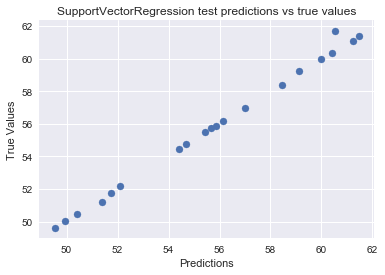

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-14.03486907  -3.72260203  -5.6186216    0.02225167 -10.19668557]
KNeighborsRegressor cross_val_score mean: -6.7101053204
Cross-Predicted R2: 0.555980220355 Cross-Predicted adjusted R2: 0.358638096068
KNeighborsRegressor test score: 0.922150489544



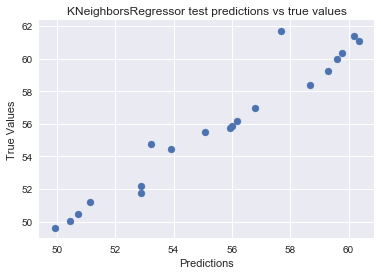

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [-0.05575613  0.96637683  0.80367536  0.98822574  0.68348459]
LinearRegression cross_val_score mean: 0.677201277643
Cross-Predicted R2: 0.978710836923 Cross-Predicted adjusted R2: 0.969248986666
LinearRegression test score: 0.993569287741



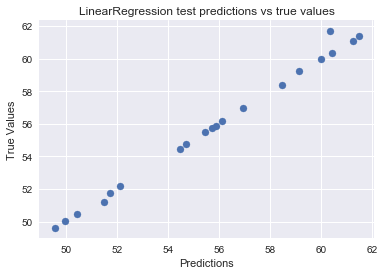


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.53333333  0.53846154  0.75        1.          0.5       ]
LogisticRegression cross_val_score mean: 0.664358974359
Cross-Predicted R2: 0.889705882353 Cross-Predicted adjusted R2: 0.84068627451
LogisticRegression test score: 0.35



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


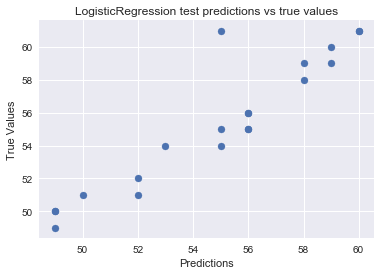

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Fragile and conflict affected situations,SupportVectorRegression,0.636479,0.968350,0.994857
1,Fragile and conflict affected situations,KNeighborsRegressor,-6.710105,0.358638,0.922150
2,Fragile and conflict affected situations,LinearRegression,0.677201,0.969249,0.993569
3,Fragile and conflict affected situations,LogisticRegression,0.664359,0.840686,0.350000


In [16]:
# setup lists for showing a summary of the World Bank special categories
lasso_coefs_list = []
combos_str = ''

combos = 'Fragile and conflict affected situations'
combos_str += '\n' + combos
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
#print('coeffs for logistic feature 1', pd.DataFrame(np.transpose(logr_coef))[:1].values)
#coef_models['logistic_reg'] = logr_coef
all_summary_models = summary_models.copy()
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 52)
test_data.shape after dropping life_expectancy and target nulls (40, 49)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00319825904114
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-2.90548579 -2.61084307  0.79022576  0.98133011  0.26336318]
Lasso cross_val_score mean: -0.696281963015
Cross-Predicted R2: 0.951814407887 Cross-Predicted adjusted R2: 1.18792380924
Lasso test score: 0.995331880256

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0            rural population (% of total population)  1.524597
1   adolescent fertility rate (births per 1,000 wo...  1.013995
2   primary completion rate, female (% of relevant...  0.667361
3                     population, female (% of total)  0.471382
4          gni per capita, atlas method (current us$)  0.308280
5            prevalence of hiv, female (% ages 15-24)  0.238294
6   improved water source, urban (% of urban popul...  0.042396
7              

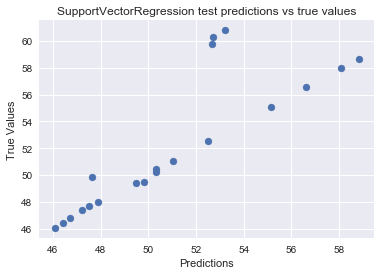

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [ -5.02272907 -10.4572383   -1.88346217  -0.88355207  -6.99346602]
KNeighborsRegressor cross_val_score mean: -5.04808952509
Cross-Predicted R2: 0.722913948007 Cross-Predicted adjusted R2: 0.399646887348
KNeighborsRegressor test score: 0.954477323514



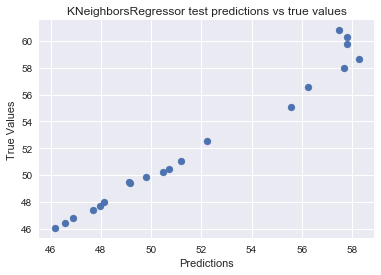

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.99364912 -1.45442122  0.26329754  0.94992361  0.06445849]
LinearRegression cross_val_score mean: 0.163381508865
Cross-Predicted R2: 0.97191591435 Cross-Predicted adjusted R2: 0.939151147758
LinearRegression test score: 0.520495524992



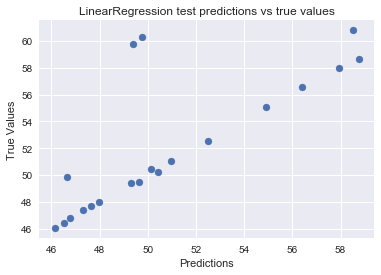


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.41176471  0.69230769  0.5         0.66666667  1.        ]
LogisticRegression cross_val_score mean: 0.654147812971


C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Cross-Predicted R2: 0.97075107072 Cross-Predicted adjusted R2: 0.936627319893
LogisticRegression test score: 0.4



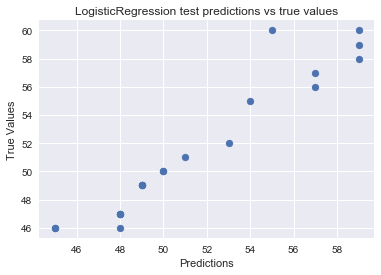

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Heavily indebted poor countries (HIPC),SupportVectorRegression,-62.199845,-1.869032,0.650864
1,Heavily indebted poor countries (HIPC),KNeighborsRegressor,-5.048090,0.399647,0.954477
2,Heavily indebted poor countries (HIPC),LinearRegression,0.163382,0.939151,0.520496
3,Heavily indebted poor countries (HIPC),LogisticRegression,0.654148,0.936627,0.400000


In [17]:
combos = 'Heavily indebted poor countries (HIPC)'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 52)
test_data.shape after dropping life_expectancy and target nulls (40, 49)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00496672233089
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-1.30603187  0.96283859  0.9077416 ]
Lasso cross_val_score mean: 0.188182772578
Cross-Predicted R2: 0.896547979997 Cross-Predicted adjusted R2: 1.40346287801
Lasso test score: 0.994552350732

Variables with non-zero coefficients chosen by Lasso
                                             variable      abs_coef
0   adolescent fertility rate (births per 1,000 wo...  2.376876e+00
1            rural population (% of total population)  1.107947e+00
2   primary completion rate, female (% of relevant...  6.524041e-01
3                birth rate, crude (per 1,000 people)  3.077201e-01
4              newborns protected against tetanus (%)  2.831226e-01
5                  rural population growth (annual %)  2.610870e-01
6                     population, female (% of total)  2.240314e-01
7       

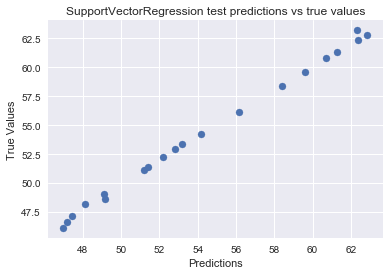

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-2.87789345 -0.96374304 -4.51973185]
KNeighborsRegressor cross_val_score mean: -2.78712278017
Cross-Predicted R2: 0.470156218168 Cross-Predicted adjusted R2: 0.173443700343
KNeighborsRegressor test score: 0.963763485079



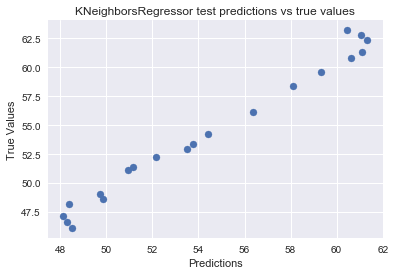

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [-0.50502948  0.78517169  0.47693703]
LinearRegression cross_val_score mean: 0.252359747853
Cross-Predicted R2: 0.901024962651 Cross-Predicted adjusted R2: 0.845598941736
LinearRegression test score: 0.996671709905



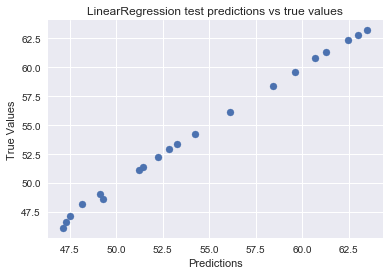


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.45   0.625  0.   ]
LogisticRegression cross_val_score mean: 0.358333333333
Cross-Predicted R2: 0.961537513252 Cross-Predicted adjusted R2: 0.939998520674
LogisticRegression test score: 0.2



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


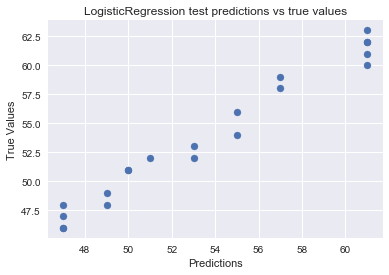

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Least developed countries: UN classification,SupportVectorRegression,-0.487313,0.784584,0.996660
1,Least developed countries: UN classification,KNeighborsRegressor,-2.787123,0.173444,0.963763
2,Least developed countries: UN classification,LinearRegression,0.252360,0.845599,0.996672
3,Least developed countries: UN classification,LogisticRegression,0.358333,0.939999,0.200000


In [18]:
combos = 'Least developed countries: UN classification'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

In [19]:
lasso_coefs_df = pd.DataFrame(columns=['Indicator', 'Count'])
for element in set(lasso_coefs_list):
    lasso_coefs_df.loc[lasso_coefs_df.shape[0]] = [element, int(lasso_coefs_list.count(element))]

lasso_coefs_df.sort_values('Count', inplace=True, ascending=False)
lasso_coefs_df = lasso_coefs_df.reset_index(drop=True)

print('Summary of predictors chosen by Lasso for World Bank special categories' + combos_str)
#lasso_coefs_df

# Get some colors from seaborn:
colours = sns.color_palette("husl", lasso_coefs_df.shape[0])
fig = plt.figure()
fig.set_size_inches(12,15)
# Reset the ticks from numbers to acutally be the names:

bar = sns.barplot(x=lasso_coefs_df.Count, y=lasso_coefs_df.Indicator, palette=colours)
bar.set_yticklabels(lasso_coefs_df.Indicator, fontsize=16)
bar.set_title('Summary of predictors chosen by Lasso', fontsize=20)
bar.set_xlabel('Count', fontsize=20)
bar.set_ylabel('Indicator', fontsize=20)
#bar.set_xticklabels(feature_names, rotation=90, fontsize=12)

Summary of predictors chosen by Lasso for World Bank special categories
Fragile and conflict affected situations
Heavily indebted poor countries (HIPC)
Least developed countries: UN classification


## <span style='color:#7D6115'>Predictors chosen by Lasso for World Bank special categories</span> <a name='lasso_sc' />
The barchart below shows the predictors chosen by Lasso ordered by most frequently found to least frequently found, note that these are absolute correlations (not signed). These are the most disadvantaged countries.

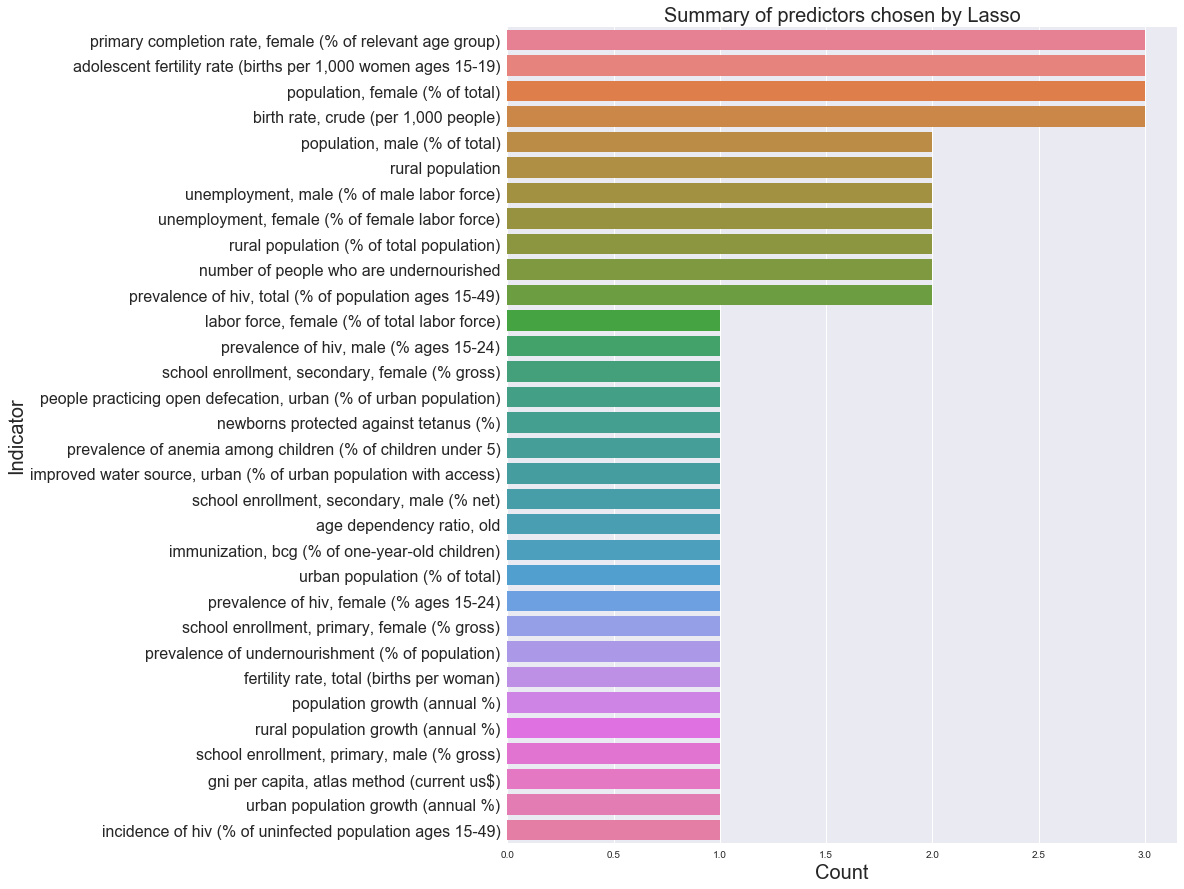

In [20]:
plt.show()

### Write the complete combo data for special categories to a csv file

In [21]:
# Store the complete combo data in a csv file for Tableau
# This will retrieve all data for each combo using the combination of indicators chosen as significant by Lasso
# Not all indicators are significant for each combo but Tableau works better when the data is complete

#print(tableau_df.columns)

tableau_df = pd.DataFrame()
for combo in combos_str.split('\n'):
    if (combo != ''):
        print(combo)
        prev_tableau_df = tableau_df.copy()
        y, y_as_float, X, col_names, tableau_df = data_process_nulls(combo, life_expectancy+list(lasso_coefs_df.Indicator.values), True, True)
        tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)

tableau_df.to_csv('./tableau1_df.csv', index=False)

Fragile and conflict affected situations
test_data.shape initial: (35, 44)
test_data.shape after removing unnecessary features and transpose (41, 35)
test_data.shape after dropping columns with more than 20 nulls (41, 33)
test_data.shape after dropping life_expectancy and target nulls (40, 30)

Heavily indebted poor countries (HIPC)
test_data.shape initial: (35, 44)
test_data.shape after removing unnecessary features and transpose (41, 35)
test_data.shape after dropping columns with more than 20 nulls (41, 35)
test_data.shape after dropping life_expectancy and target nulls (40, 32)

Least developed countries: UN classification
test_data.shape initial: (35, 44)
test_data.shape after removing unnecessary features and transpose (41, 35)
test_data.shape after dropping columns with more than 20 nulls (41, 35)
test_data.shape after dropping life_expectancy and target nulls (40, 32)



In [22]:
# Store the limited combo data in a csv file for Tableau
# This data has holes in it as it only has values for the indicators chosen as significant by Lasso
# The set of indicators will be different for each combo although there is some degree of commonality

#temp_cols = list(tableau_df.columns[2:])
#temp_cols.remove(y_indicator)
#temp_cols = ['Combo', 'Year'] + [y_indicator] + temp_cols
#tableau_df = tableau_df[temp_cols]
#tableau_df.to_csv('./tableau1_df.csv', index=False)

## <span style='color:#7D6115'>Start of country combinations</span> <a name='country_combinations' />

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 52)
test_data.shape after dropping life_expectancy and target nulls (40, 49)

optimal_lasso: 0.00362207269735
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-7.270306    0.98150442  0.92992888  0.88543298  0.52556505]
Lasso cross_val_score mean: -0.789574933241
Cross-Predicted R2: 0.830649051231 Cross-Predicted adjusted R2: 1.6604687002
Lasso test score: 0.998069209267



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0   adolescent fertility rate (births per 1,000 wo...  2.836075
1                birth rate, crude (per 1,000 people)  0.444070
2                     population, female (% of total)  0.421209
3        school enrollment, primary, female (% gross)  0.249438
4            rural population (% of total population)  0.245747
5                                    rural population  0.201685
6          school enrollment, secondary, male (% net)  0.155257
7   prevalence of hiv, total (% of population ages...  0.054241
8              newborns protected against tetanus (%)  0.051075
9              prevalence of hiv, male (% ages 15-24)  0.024322
10            number of people who are undernourished  0.014766
11       school enrollment, secondary, male (% gross)  0.014702
12         unemployment, male (% of male labor force)  0.010408
13  improved sanitation facilities, urban (% of ur.

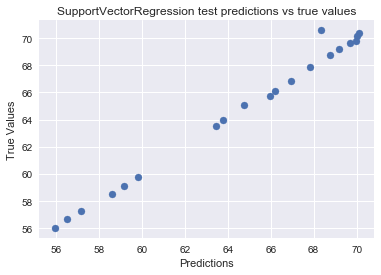

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-7.88346353 -2.60728833 -1.8930547  -2.10305634 -6.41243283]
KNeighborsRegressor cross_val_score mean: -4.17985914577
Cross-Predicted R2: 0.719606833335 Cross-Predicted adjusted R2: 0.502939386366
KNeighborsRegressor test score: 0.977519142817



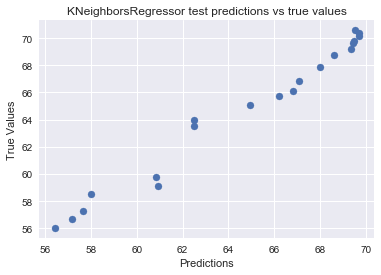

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.09447215  0.93536867  0.92147407  0.72504355  0.51572556]
LinearRegression cross_val_score mean: 0.638416800576
Cross-Predicted R2: 0.978458696526 Cross-Predicted adjusted R2: 0.961813143842
LinearRegression test score: 0.994168014403



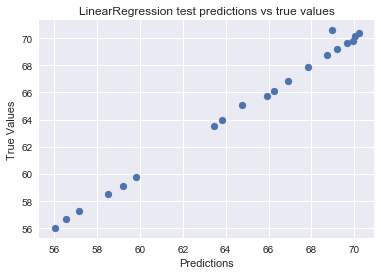


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.5625      0.75        0.71428571  0.66666667  0.        ]
LogisticRegression cross_val_score mean: 0.53869047619


C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Cross-Predicted R2: 0.977304249149 Cross-Predicted adjusted R2: 0.959766623491
LogisticRegression test score: 0.4



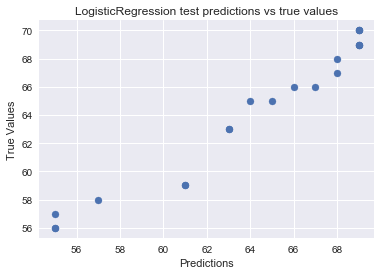

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Arab World,SupportVectorRegression,-0.004219,0.976273,0.989047
1,Arab World,KNeighborsRegressor,-4.179859,0.502939,0.977519
2,Arab World,LinearRegression,0.638417,0.961813,0.994168
3,Arab World,LogisticRegression,0.538690,0.959767,0.400000


In [23]:
# setup lists for showing a summary of the World Bank geographic groupings
lasso_coefs_list = []
combos_str = ''

combos = 'Arab World'
combos_str += '\n' + combos
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 53)
test_data.shape after dropping life_expectancy and target nulls (40, 50)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00109911139436
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-0.30462862 -0.04336177 -3.34026665  0.85829086 -0.56535428]
Lasso cross_val_score mean: -0.679064091018
Cross-Predicted R2: 0.92277263654 Cross-Predicted adjusted R2: 1.27380610681
Lasso test score: 0.99707597664

Variables with non-zero coefficients chosen by Lasso
                                             variable      abs_coef
0   age dependency ratio (% of working-age populat...  7.298927e-01
1   adolescent fertility rate (births per 1,000 wo...  2.478974e-01
2                                    rural population  1.982114e-01
3                           age dependency ratio, old  1.241193e-01
4        labor force, female (% of total labor force)  1.131418e-01
5                     population, female (% of total)  9.099704e-02
6          school enrollment, primary, female (% net)

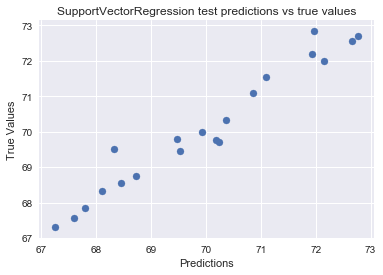

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [ -6.135272   -10.8787542   -9.22460976  -1.19656467  -6.92385303]
KNeighborsRegressor cross_val_score mean: -6.87181073167
Cross-Predicted R2: 0.560496352744 Cross-Predicted adjusted R2: 0.220879898047
KNeighborsRegressor test score: 0.952813477676



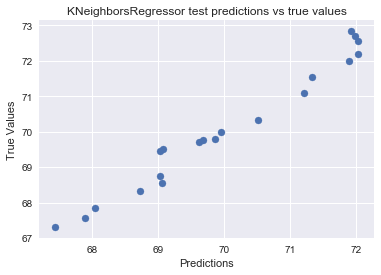

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.94425598  0.92694553 -0.40115562  0.96280168  0.94298928]
LinearRegression cross_val_score mean: 0.675167369932
Cross-Predicted R2: 0.994624419389 Cross-Predicted adjusted R2: 0.990470561643
LinearRegression test score: 0.987077217188



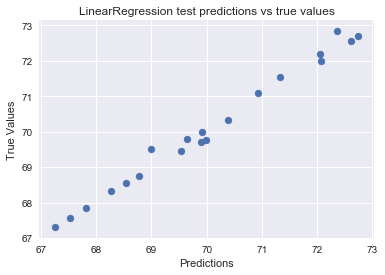


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.33333333  0.75        1.          1.          0.57142857]
LogisticRegression cross_val_score mean: 0.730952380952
Cross-Predicted R2: 0.868891537545 Cross-Predicted adjusted R2: 0.76758045292
LogisticRegression test score: 0.9



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


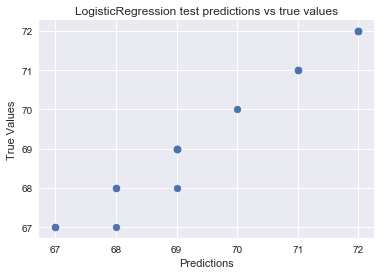

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Caribbean small states,SupportVectorRegression,-14.536338,0.079796,0.946476
1,Caribbean small states,KNeighborsRegressor,-6.871811,0.220880,0.952813
2,Caribbean small states,LinearRegression,0.675167,0.990471,0.987077
3,Caribbean small states,LogisticRegression,0.730952,0.767580,0.900000


In [24]:
combos = 'Caribbean small states'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 39)
test_data.shape after dropping life_expectancy and target nulls (40, 36)

optimal_lasso: 0.00205570316649
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-2.67603733 -3.73288514  0.59908837  0.44151257 -1.33302544]
Lasso cross_val_score mean: -1.34026939289
Cross-Predicted R2: 0.90537970424 Cross-Predicted adjusted R2: -0.230063844875
Lasso test score: 0.991524425449

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0          gni per capita, atlas method (current us$)  1.004587
1   adolescent fertility rate (births per 1,000 wo...  0.506480
2                           age

C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

(20, 44)
test_data.shape after removing unnecessary features and transpose (41, 20)
test_data.shape after dropping columns with more than 20 nulls (41, 20)
test_data.shape after dropping life_expectancy and target nulls (40, 17)

################################################################################
SupportVectorRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
SupportVectorRegression cross_val_score: [ -2.86740631 -17.05471476  -0.85748852   0.3466291   -7.56854231]
SupportVectorRegression cross_val_score mean: -5.60030456221
Cross-Predicted R2: 0.682837109174 Cross-Predicted adjusted R2: 0.437756693536
SupportVectorRegression test score: 0.970919588037



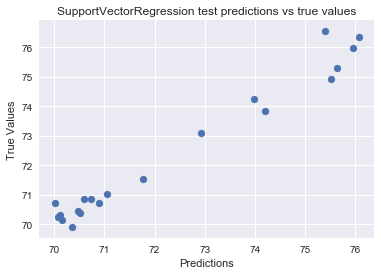

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-2.23178894 -1.83598862 -1.95860197 -4.82238661 -4.05192106]
KNeighborsRegressor cross_val_score mean: -2.9801374391
Cross-Predicted R2: 0.719596549749 Cross-Predicted adjusted R2: 0.502921156374
KNeighborsRegressor test score: 0.951909734781



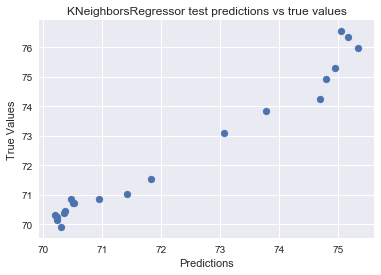

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [-27.60585698  -7.28024768  -0.45480124   0.83350327   0.41879439]
LinearRegression cross_val_score mean: -6.81772164761
Cross-Predicted R2: 0.919511765949 Cross-Predicted adjusted R2: 0.857316312363
LinearRegression test score: 0.977993342678



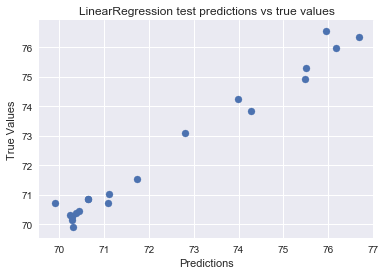


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.54545455  0.8         0.875       1.          0.75      ]
LogisticRegression cross_val_score mean: 0.794090909091
Cross-Predicted R2: 0.944912012242 Cross-Predicted adjusted R2: 0.902344021701
LogisticRegression test score: 0.75



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


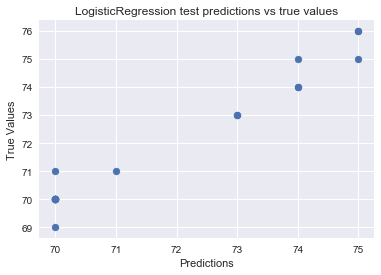

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Central Europe and the Baltics,SupportVectorRegression,-5.600305,0.437757,0.970920
1,Central Europe and the Baltics,KNeighborsRegressor,-2.980137,0.502921,0.951910
2,Central Europe and the Baltics,LinearRegression,-6.817722,0.857316,0.977993
3,Central Europe and the Baltics,LogisticRegression,0.794091,0.902344,0.750000


In [25]:
combos = 'Central Europe and the Baltics'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 46)
test_data.shape after dropping life_expectancy and target nulls (40, 43)

C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa



optimal_lasso: 0.00580879624876
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-2.50925391  0.94626416  0.80269979  0.99814241 -2.38692096]
Lasso cross_val_score mean: -0.429813700332
Cross-Predicted R2: 0.900084174895 Cross-Predicted adjusted R2: 1.97417929478
Lasso test score: 0.995853287603

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0   age dependency ratio (% of working-age populat...  1.751120
1                birth rate, crude (per 1,000 people)  0.480581
2            fertility rate, total (births per woman)  0.305438
3                         age dependency ratio, young  0.233931
4                           age dependency ratio, old  0.200578
5   improved sanitation facilities, urban (% of ur...  0.148051
6        school enrollment, primary, female (% gross)  0.128373
7            

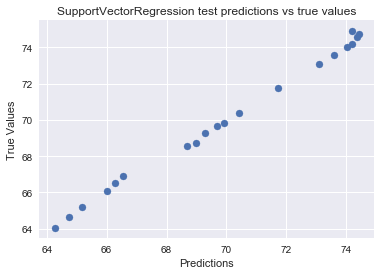

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-6.01821535 -3.72318257 -3.21347524 -0.57117047 -7.49123078]
KNeighborsRegressor cross_val_score mean: -4.20345488404
Cross-Predicted R2: 0.72781956763 Cross-Predicted adjusted R2: 0.620891540628
KNeighborsRegressor test score: 0.982879465755



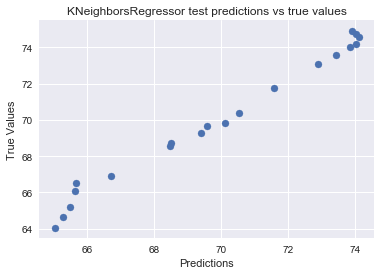

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.93104883  0.10910358  0.80232854  0.91008221 -1.15488008]
LinearRegression cross_val_score mean: 0.31953661792
Cross-Predicted R2: 0.982901576932 Cross-Predicted adjusted R2: 0.976184339298
LinearRegression test score: 0.99473272523



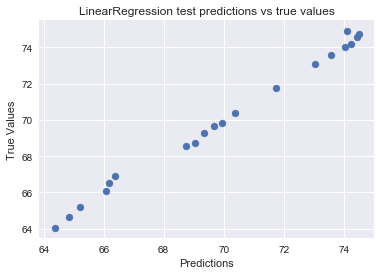


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.53846154  0.90909091  0.77777778  0.75        0.66666667]
LogisticRegression cross_val_score mean: 0.728399378399
Cross-Predicted R2: 0.973039215686 Cross-Predicted adjusted R2: 0.962447478992
LogisticRegression test score: 0.5



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


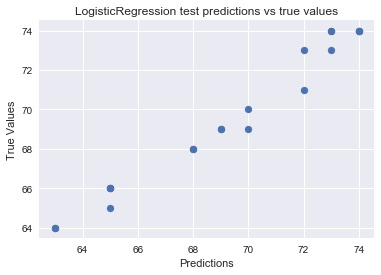

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,East Asia & Pacific,SupportVectorRegression,-0.702378,0.901338,0.996111
1,East Asia & Pacific,KNeighborsRegressor,-4.203455,0.620892,0.982879
2,East Asia & Pacific,LinearRegression,0.319537,0.976184,0.994733
3,East Asia & Pacific,LogisticRegression,0.728399,0.962447,0.500000


In [26]:
combos = 'East Asia & Pacific'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 46)
test_data.shape after dropping life_expectancy and target nulls (40, 43)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00316157054718
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-19.19964844   0.77724754   0.59681778   0.94722958  -3.94626016]
Lasso cross_val_score mean: -4.16492274021
Cross-Predicted R2: 0.743076122947 Cross-Predicted adjusted R2: 3.50500780127
Lasso test score: 0.997504105983

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0                         age dependency ratio, young  1.022346
1                           age dependency ratio, old  0.602921
2       school enrollment, tertiary, female (% gross)  0.465987
3                                    rural population  0.422585
4   improved water source, urban (% of urban popul...  0.290350
5   adolescent fertility rate (births per 1,000 wo...  0.224325
6   prevalence of anemia among children (% of chil...  0.069989
7        sc

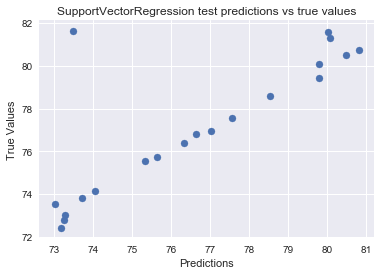

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-9.54202357 -4.2019629  -3.1512535  -1.72840519 -6.48431001]
KNeighborsRegressor cross_val_score mean: -5.02159103363
Cross-Predicted R2: 0.730269535795 Cross-Predicted adjusted R2: 0.561687995667
KNeighborsRegressor test score: 0.965751346489



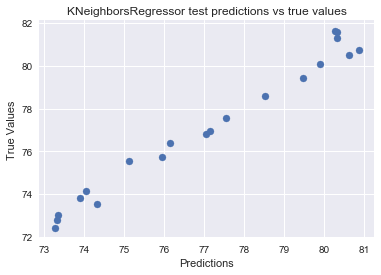

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [-8.54019434  0.83369733  0.82986907  0.71524915 -1.77026544]
LinearRegression cross_val_score mean: -1.58632884633
Cross-Predicted R2: 0.872581560447 Cross-Predicted adjusted R2: 0.792945035726
LinearRegression test score: 0.930987956277



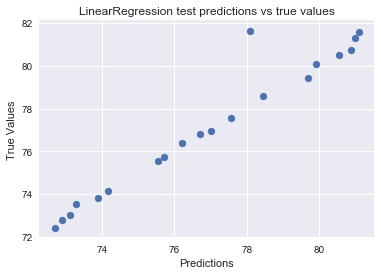


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.5         1.          0.7         0.71428571  0.66666667]
LogisticRegression cross_val_score mean: 0.71619047619
Cross-Predicted R2: 0.964282815164 Cross-Predicted adjusted R2: 0.941959574641
LogisticRegression test score: 0.65



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


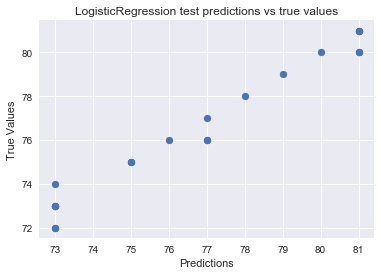

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Euro area,SupportVectorRegression,-72.938197,-5.219011,0.631137
1,Euro area,KNeighborsRegressor,-5.021591,0.561688,0.965751
2,Euro area,LinearRegression,-1.586329,0.792945,0.930988
3,Euro area,LogisticRegression,0.716190,0.941960,0.650000


In [27]:
combos = 'Euro area'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 47)
test_data.shape after dropping life_expectancy and target nulls (40, 44)

optimal_lasso: 0.00144100137843
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [ 0.86562199 -1.73681229  0.31271377  0.24013925 -1.28734707]
Lasso cross_val_score mean: -0.321136868261
Cross-Predicted R2: 0.902014305532 Cross-Predicted adjusted R2: 1.76428841685
Lasso test score: 0.972557277648

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0   age dependency ratio (% of working-age populat...  0.593948
1          gni per capita, atlas method (current us$)  0.568565
2   people practicing open defe

C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

(41, 19)
test_data.shape after dropping columns with more than 20 nulls (41, 19)
test_data.shape after dropping life_expectancy and target nulls (40, 16)

################################################################################
SupportVectorRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
SupportVectorRegression cross_val_score: [-0.7175217  -6.81040707 -0.82759782  0.1403936  -1.53382046]
SupportVectorRegression cross_val_score mean: -1.9497906886
Cross-Predicted R2: 0.822246924854 Cross-Predicted adjusted R2: 0.698592611709
SupportVectorRegression test score: 0.673358837428



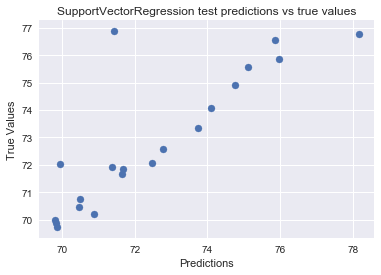

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-7.95410643 -3.64162678 -2.20427846 -1.87550771 -6.55863745]
KNeighborsRegressor cross_val_score mean: -4.44683136406
Cross-Predicted R2: 0.661321665166 Cross-Predicted adjusted R2: 0.425719345281
KNeighborsRegressor test score: 0.919579837287



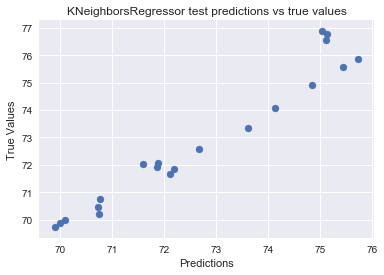

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.23424005 -0.67225847  0.59435577 -0.21110947 -0.88568906]
LinearRegression cross_val_score mean: -0.188092237749
Cross-Predicted R2: 0.915286117283 Cross-Predicted adjusted R2: 0.856354720611
LinearRegression test score: 0.97906589007



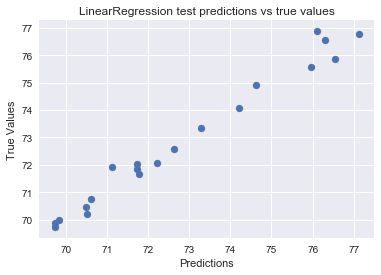


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.36363636  0.7         0.88888889  1.          1.        ]
LogisticRegression cross_val_score mean: 0.790505050505
Cross-Predicted R2: 0.937357630979 Cross-Predicted adjusted R2: 0.893780330791
LogisticRegression test score: 0.5



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


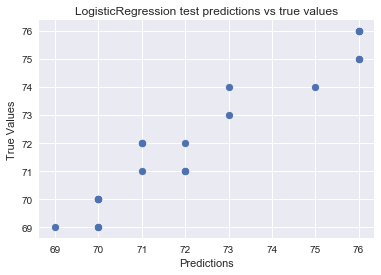

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Europe & Central Asia,SupportVectorRegression,-1.949791,0.698593,0.673359
1,Europe & Central Asia,KNeighborsRegressor,-4.446831,0.425719,0.919580
2,Europe & Central Asia,LinearRegression,-0.188092,0.856355,0.979066
3,Europe & Central Asia,LogisticRegression,0.790505,0.893780,0.500000


In [28]:
combos = 'Europe & Central Asia'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 46)
test_data.shape after dropping life_expectancy and target nulls (40, 43)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00206537639834
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-15.36643408   0.87036565   0.93669802   0.93804658  -3.29396293]
Lasso cross_val_score mean: -3.18305734967
Cross-Predicted R2: 0.835701685946 Cross-Predicted adjusted R2: 2.60190856203
Lasso test score: 0.993976739998

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0   adolescent fertility rate (births per 1,000 wo...  0.802883
1                           age dependency ratio, old  0.534469
2                         age dependency ratio, young  0.492617
3       school enrollment, tertiary, female (% gross)  0.488482
4                                  labor force, total  0.388648
5   prevalence of anemia among children (% of chil...  0.139881
6        school enrollment, primary, female (% gross)  0.103402
7   age dep

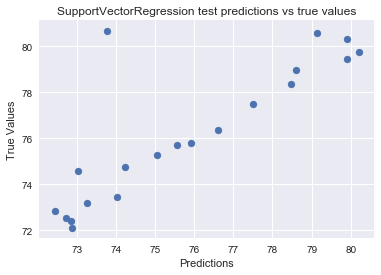

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-14.87228042  -1.43899825  -0.42046626  -1.3318448   -7.99582872]
KNeighborsRegressor cross_val_score mean: -5.21188369086
Cross-Predicted R2: 0.739015615089 Cross-Predicted adjusted R2: 0.537345863113
KNeighborsRegressor test score: 0.95566221847



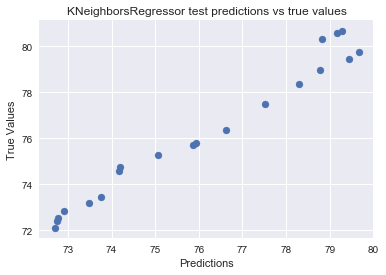

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.74150642 -1.65460619  0.91243796  0.90120827 -1.26053027]
LinearRegression cross_val_score mean: -0.0719967588953
Cross-Predicted R2: 0.955761784146 Cross-Predicted adjusted R2: 0.921577708259
LinearRegression test score: 0.939548682742



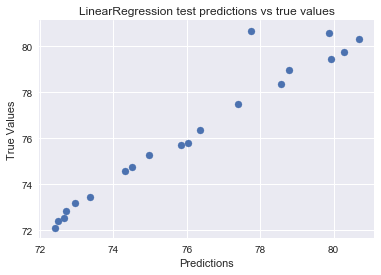


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.36363636  0.88888889  0.77777778  0.75        0.66666667]
LogisticRegression cross_val_score mean: 0.689393939394
Cross-Predicted R2: 0.942852040361 Cross-Predicted adjusted R2: 0.898692253367
LogisticRegression test score: 0.55



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


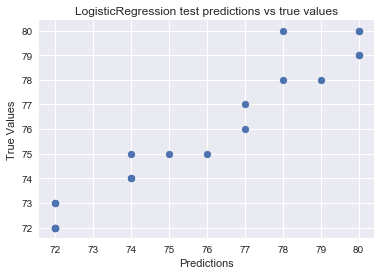

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,European Union,SupportVectorRegression,-8.023440,0.446863,0.680757
1,European Union,KNeighborsRegressor,-5.211884,0.537346,0.955662
2,European Union,LinearRegression,-0.071997,0.921578,0.939549
3,European Union,LogisticRegression,0.689394,0.898692,0.550000


In [29]:
combos = 'European Union'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 55)
test_data.shape after dropping life_expectancy and target nulls (40, 52)

optimal_lasso: 0.00975193321276
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-2.88499477  0.99910222  0.99236278  0.94346522  0.92713576]
Lasso cross_val_score mean: 0.195414240649
Cross-Predicted R2: 0.962087181187 Cross-Predicted adjusted R2: 1.11373845644
Lasso test score: 0.999720627368

Variables with non-zero coefficients chosen by Lasso
                                            variable      abs_coef
0  age dependency ratio (% of working-age populat...  3.034865e+00
1                       population growth (annual %)  5.475055e-01
2  primary completion r

C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Cross-Predicted adjusted R2: 0.989073073657
SupportVectorRegression test score: 0.985793314077



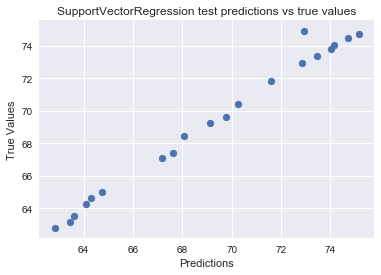

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [ -5.42522153  -0.79361602  -0.8285078   -2.31475596 -19.49842503]
KNeighborsRegressor cross_val_score mean: -5.77210526934
Cross-Predicted R2: 0.811814201706 Cross-Predicted adjusted R2: 0.755358462218
KNeighborsRegressor test score: 0.984069890055



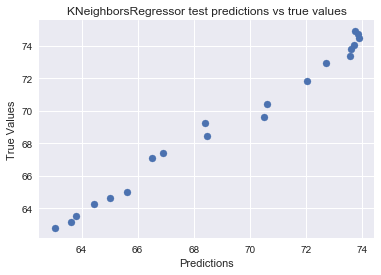

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.98401587  0.99300539  0.98714197  0.99582832  0.95213833]
LinearRegression cross_val_score mean: 0.982425976629
Cross-Predicted R2: 0.999457053853 Cross-Predicted adjusted R2: 0.99929417001
LinearRegression test score: 0.999577821161



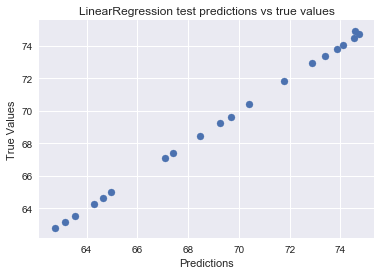


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.46153846  0.76923077  0.6         0.66666667  1.        ]
LogisticRegression cross_val_score mean: 0.699487179487
Cross-Predicted R2: 0.974293059126 Cross-Predicted adjusted R2: 0.966580976864
LogisticRegression test score: 0.4



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


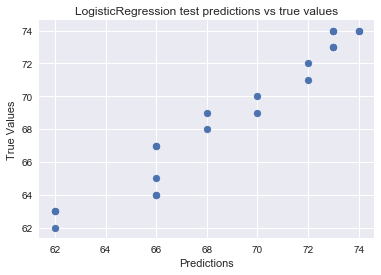

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Latin America & Caribbean,SupportVectorRegression,0.668871,0.989073,0.985793
1,Latin America & Caribbean,KNeighborsRegressor,-5.772105,0.755358,0.984070
2,Latin America & Caribbean,LinearRegression,0.982426,0.999294,0.999578
3,Latin America & Caribbean,LogisticRegression,0.699487,0.966581,0.400000


In [30]:
combos = 'Latin America & Caribbean'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 55)
test_data.shape after dropping life_expectancy and target nulls (40, 52)

optimal_lasso: 0.0109248787285
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-8.37742441  0.97758977  0.91195259  0.87087638 -2.28593691]
Lasso cross_val_score mean: -1.58058851558
Cross-Predicted R2: 0.905664805182 Cross-Predicted adjusted R2: 1.28300558445
Lasso test score: 0.996436677063

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0   adolescent fertility rate (births per 1,000 wo...  3.456752
1        school enrollment, secondary, male (% gross)  0.762968
2                                

C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

SupportVectorRegression cross_val_score mean: 0.373121384339
Cross-Predicted R2: 0.981364336697 Cross-Predicted adjusted R2: 0.974043183256
SupportVectorRegression test score: 0.997168289553



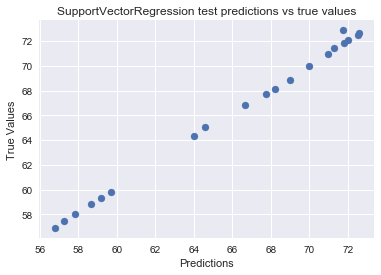

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-18.18996784  -1.29098212  -3.4275241   -5.97959166  -8.08012626]
KNeighborsRegressor cross_val_score mean: -7.39363839543
Cross-Predicted R2: 0.707703533071 Cross-Predicted adjusted R2: 0.592872778205
KNeighborsRegressor test score: 0.970739756833



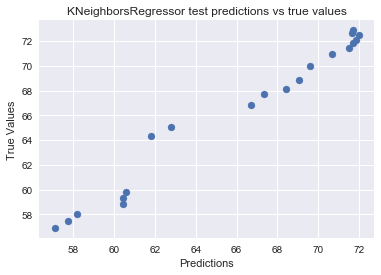

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.20922189  0.80851908 -0.18156918  0.68819157 -0.75093598]
LinearRegression cross_val_score mean: 0.154685473422
Cross-Predicted R2: 0.977110034195 Cross-Predicted adjusted R2: 0.968117547629
LinearRegression test score: 0.995475426999



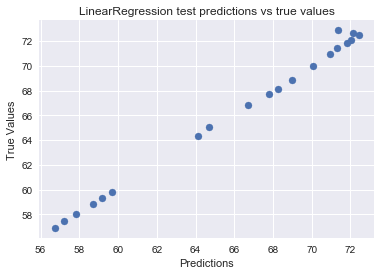


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.29411765  0.66666667  0.5         1.          0.5       ]
LogisticRegression cross_val_score mean: 0.592156862745
Cross-Predicted R2: 0.940244995518 Cross-Predicted adjusted R2: 0.916769815186
LogisticRegression test score: 0.4



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


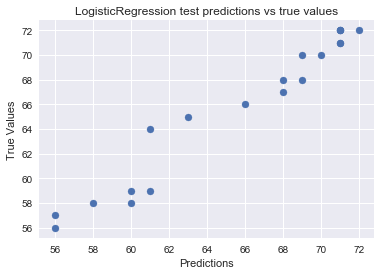

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Middle East & North Africa,SupportVectorRegression,0.373121,0.974043,0.997168
1,Middle East & North Africa,KNeighborsRegressor,-7.393638,0.592873,0.970740
2,Middle East & North Africa,LinearRegression,0.154685,0.968118,0.995475
3,Middle East & North Africa,LogisticRegression,0.592157,0.916770,0.400000


In [31]:
combos = 'Middle East & North Africa'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 47)
test_data.shape after dropping life_expectancy and target nulls (40, 44)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00543161908278
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-5.35837411  0.55321382  0.84538419  0.62209806 -0.64926711]
Lasso cross_val_score mean: -0.797389030187
Cross-Predicted R2: 0.865398686642 Cross-Predicted adjusted R2: 2.04989024419
Lasso test score: 0.991935255572

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0          gni per capita, atlas method (current us$)  0.440854
1            rural population (% of total population)  0.418927
2       school enrollment, tertiary, female (% gross)  0.308755
3                         age dependency ratio, young  0.205436
4   age dependency ratio (% of working-age populat...  0.186469
5                  rural population growth (annual %)  0.159758
6   adolescent fertility rate (births per 1,000 wo...  0.098023
7   improved wa

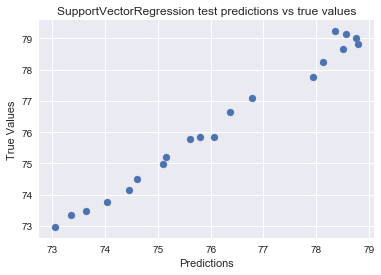

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [ -4.91911283  -4.10560526  -0.89992201  -2.352401   -10.01892807]
KNeighborsRegressor cross_val_score mean: -4.45919383618
Cross-Predicted R2: 0.746423050899 Cross-Predicted adjusted R2: 0.587937457712
KNeighborsRegressor test score: 0.931628138742



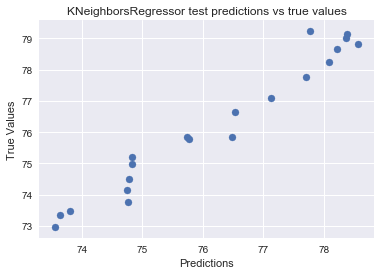

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [-2.08306893  0.89784791  0.7761715   0.80865609  0.09220523]
LinearRegression cross_val_score mean: 0.0983623606357
Cross-Predicted R2: 0.932809480685 Cross-Predicted adjusted R2: 0.890815406113
LinearRegression test score: 0.961452527441



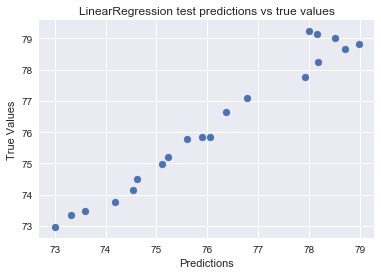


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.63636364  0.9         0.875       0.83333333  0.6       ]
LogisticRegression cross_val_score mean: 0.768939393939
Cross-Predicted R2: 0.888084265964 Cross-Predicted adjusted R2: 0.818136932192
LogisticRegression test score: 0.6



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


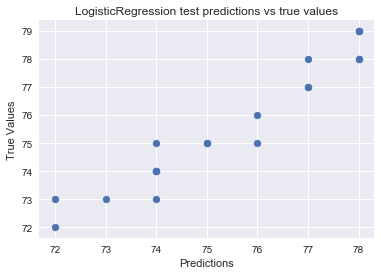

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,North America,SupportVectorRegression,-31.449267,-0.784315,0.980612
1,North America,KNeighborsRegressor,-4.459194,0.587937,0.931628
2,North America,LinearRegression,0.098362,0.890815,0.961453
3,North America,LogisticRegression,0.768939,0.818137,0.600000


In [32]:
combos = 'North America'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 43)
test_data.shape after dropping life_expectancy and target nulls (40, 40)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00316514999973
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [ 0.45447041  0.82953289  0.99510675  0.92531064 -0.27917367]
Lasso cross_val_score mean: 0.585049403167
Cross-Predicted R2: 0.985909630897 Cross-Predicted adjusted R2: 1.54952439502
Lasso test score: 0.99876493283

Variables with non-zero coefficients chosen by Lasso
                                             variable  abs_coef
0   age dependency ratio (% of working-age populat...  1.267505
1                                    rural population  0.828880
2   adolescent fertility rate (births per 1,000 wo...  0.411633
3            fertility rate, total (births per woman)  0.278408
4   immunization, dpt (% of children ages 12-23 mo...  0.078755
5      school enrollment, secondary, female (% gross)  0.077385
6          school enrollment, primary, male (% gross)  0.057585
7                

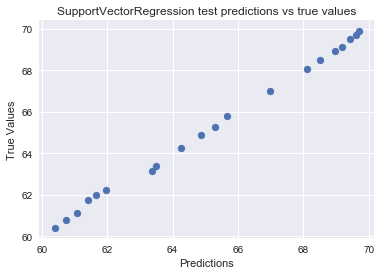

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-6.5877889  -9.29187352 -0.52073014 -4.6062742  -6.29124293]
KNeighborsRegressor cross_val_score mean: -5.45958193703
Cross-Predicted R2: 0.76846201739 Cross-Predicted adjusted R2: 0.607392116443
KNeighborsRegressor test score: 0.983166402761



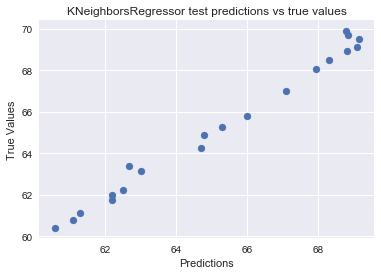

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.91157208  0.66113585  0.37511905  0.7974143   0.99342478]
LinearRegression cross_val_score mean: 0.747733212296
Cross-Predicted R2: 0.988518936792 Cross-Predicted adjusted R2: 0.980532110213
LinearRegression test score: 0.998419034349



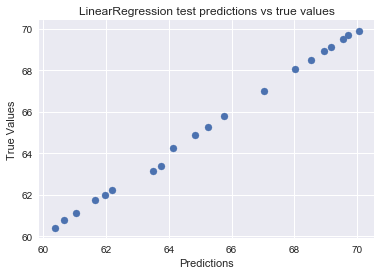


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.63636364  0.9         0.6         0.8         0.5       ]
LogisticRegression cross_val_score mean: 0.687272727273
Cross-Predicted R2: 0.964367901418 Cross-Predicted adjusted R2: 0.939580354578
LogisticRegression test score: 0.7



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


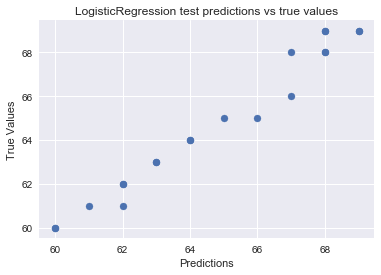

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Pacific island small states,SupportVectorRegression,-8.352695,0.224333,0.997715
1,Pacific island small states,KNeighborsRegressor,-5.459582,0.607392,0.983166
2,Pacific island small states,LinearRegression,0.747733,0.980532,0.998419
3,Pacific island small states,LogisticRegression,0.687273,0.939580,0.700000


In [33]:
combos = 'Pacific island small states'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 52)
test_data.shape after dropping life_expectancy and target nulls (40, 49)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.0185490648789
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [-1.39654579  0.98570144  0.92537223]
Lasso cross_val_score mean: 0.171509290318
Cross-Predicted R2: 0.881181040157 Cross-Predicted adjusted R2: 1.46339394339
Lasso test score: 0.999328586726

Variables with non-zero coefficients chosen by Lasso
                                            variable      abs_coef
0                                   rural population  2.141761e+00
1           fertility rate, total (births per woman)  1.992507e+00
2           rural population (% of total population)  5.793842e-01
3                    population, female (% of total)  3.182913e-01
4       tuberculosis case detection rate (all forms)  8.409743e-02
5             newborns protected against tetanus (%)  2.950832e-02
6                 urban population growth (annual %)  8.625996e-03
7                

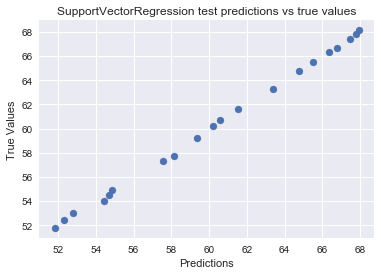

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [-5.35076452 -1.0075666  -6.31487521]
KNeighborsRegressor cross_val_score mean: -4.22440211084
Cross-Predicted R2: 0.425632144204 Cross-Predicted adjusted R2: 0.227574262895
KNeighborsRegressor test score: 0.980125825705



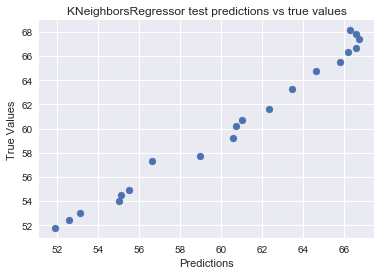

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [ 0.94055787  0.95295716 -0.85896994]
LinearRegression cross_val_score mean: 0.344848363698
Cross-Predicted R2: 0.948080245453 Cross-Predicted adjusted R2: 0.930176881816
LinearRegression test score: 0.99935668628



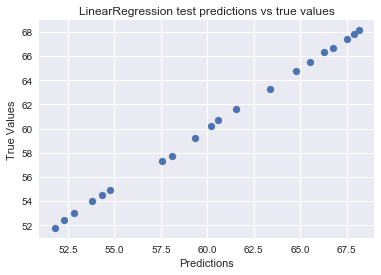


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.38888889  0.5625      0.66666667]
LogisticRegression cross_val_score mean: 0.539351851852
Cross-Predicted R2: 0.954705586311 Cross-Predicted adjusted R2: 0.93908682297
LogisticRegression test score: 0.3



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


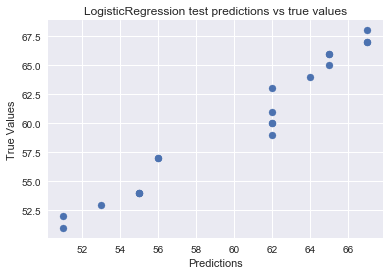

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,South Asia,SupportVectorRegression,0.509271,0.942332,0.999094
1,South Asia,KNeighborsRegressor,-4.224402,0.227574,0.980126
2,South Asia,LinearRegression,0.344848,0.930177,0.999357
3,South Asia,LogisticRegression,0.539352,0.939087,0.300000


In [34]:
combos = 'South Asia'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

Processing nulls for Lasso predictor selection
test_data.shape initial: (217, 44)
test_data.shape after removing unnecessary features and transpose (41, 217)
test_data.shape after dropping columns with more than 20 nulls (41, 53)
test_data.shape after dropping life_expectancy and target nulls (40, 50)



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

optimal_lasso: 0.00188087144762
################################################################################
Lasso # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Lasso cross_val_score: [ -1.77719598  -6.75729156 -83.4526898    0.97041766  -1.46364076]
Lasso cross_val_score mean: -18.4960800874
Cross-Predicted R2: 0.842373847781 Cross-Predicted adjusted R2: 1.55885635787
Lasso test score: 0.980054950847

Variables with non-zero coefficients chosen by Lasso
                                             variable      abs_coef
0                     population, female (% of total)  7.312736e-01
1   adolescent fertility rate (births per 1,000 wo...  5.884174e-01
2      school enrollment, secondary, female (% gross)  4.936389e-01
3   prevalence of tuberculosis (per 100,000 popula...  4.575632e-01
4   primary completion rate, female (% of relevant...  3.824957e-01
5                        population growth (annual %)  2.610886e-01
6                birth rate, crude (per 1,000 p

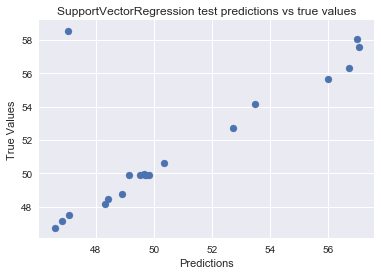

################################################################################
KNeighborsRegressor # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
KNeighborsRegressor cross_val_score: [ -5.01571266  -5.41325308 -27.34263174  -0.06532407  -6.6012026 ]
KNeighborsRegressor cross_val_score mean: -8.88762482797
Cross-Predicted R2: 0.562532174775 Cross-Predicted adjusted R2: 0.0521530453454
KNeighborsRegressor test score: 0.928998673029



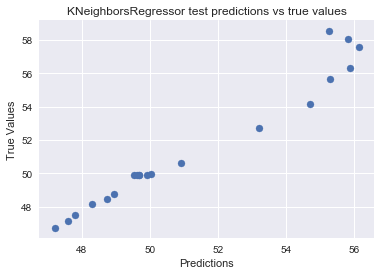

################################################################################
LinearRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LinearRegression cross_val_score: [  0.73637169   0.43778436 -22.19808668   0.96829679   0.11502989]
LinearRegression cross_val_score mean: -3.98812079031
Cross-Predicted R2: 0.956627551148 Cross-Predicted adjusted R2: 0.906026360821
LinearRegression test score: 0.255105631478



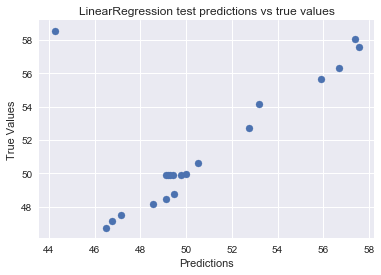


################################################################################
LogisticRegression # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
LogisticRegression cross_val_score: [ 0.6         0.75        0.66666667  1.          0.66666667]
LogisticRegression cross_val_score mean: 0.736666666667
Cross-Predicted R2: 0.962684246533 Cross-Predicted adjusted R2: 0.919149200821
LogisticRegression test score: 0.5



C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\trade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


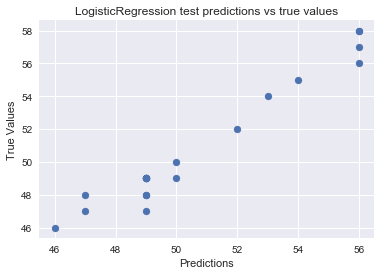

,combos,model,CrossValScore_mean,CrossPredictedAdj_R2,test_score
0,Sub-Saharan Africa,SupportVectorRegression,-126.311662,-41.777092,0.516133
1,Sub-Saharan Africa,KNeighborsRegressor,-8.887625,0.052153,0.928999
2,Sub-Saharan Africa,LinearRegression,-3.988121,0.906026,0.255106
3,Sub-Saharan Africa,LogisticRegression,0.736667,0.919149,0.500000


In [35]:
combos = 'Sub-Saharan Africa'
combos_str += '\n' + combos
prev_tableau_df = tableau_df.copy()
prev_coef_models = coef_models.copy()
summary_models, X_train, X_test, y_train, y_test, lasso_coefs, tableau_df, coef_models = run_lasso(combos, combos_indicators)
tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)
lasso_coefs_list += list(lasso_coefs)
linr_coef, logr_coef = run_other_models(combos, list(lasso_coefs) + life_expectancy, summary_models)
coef_models['linear_reg'] = linr_coef
coef_models = pd.concat([prev_coef_models, coef_models], axis=0, ignore_index=True)
all_summary_models = all_summary_models.append(summary_models, ignore_index=True)
summary_models

### Setup dataframe with the most commonly occuring indicators

In [36]:
lasso_coefs_df = pd.DataFrame(columns=['Indicator', 'Count'])
for element in set(lasso_coefs_list):
    lasso_coefs_df.loc[lasso_coefs_df.shape[0]] = [element, int(lasso_coefs_list.count(element))]
lasso_coefs_df.sort_values('Count', inplace=True, ascending=False)
lasso_coefs_df = lasso_coefs_df.reset_index(drop=True)
lasso_coefs_df = lasso_coefs_df[lasso_coefs_df.Count > 1]

print('Summary of predictors chosen 2 or more times by Lasso for World Bank geographic groupings' + combos_str)
#lasso_coefs_df

# Get some colors from seaborn:
colours = sns.color_palette("husl", lasso_coefs_df.shape[0])
fig = plt.figure()
fig.set_size_inches(12,20)
# Reset the ticks from numbers to acutally be the names:

bar = sns.barplot(x=lasso_coefs_df.Count, y=lasso_coefs_df.Indicator, palette=colours)
bar.set_yticklabels(lasso_coefs_df.Indicator, fontsize=16)
bar.set_title('Summary of predictors chosen by Lasso', fontsize=20)
bar.set_xlabel('Count', fontsize=20)
bar.set_ylabel('Indicator', fontsize=20)

Summary of predictors chosen 2 or more times by Lasso for World Bank geographic groupings
Arab World
Caribbean small states
Central Europe and the Baltics
East Asia & Pacific
Euro area
Europe & Central Asia
European Union
Latin America & Caribbean
Middle East & North Africa
North America
Pacific island small states
South Asia
Sub-Saharan Africa


## <span style='color:#7D6115'>Predictors chosen by Lasso for Geographic Groupings</span> <a name='lasso_cc' />
The barchart below shows the predictors chosen by Lasso ordered by most frequently found to least frequently found, note that these are absolute correlations (not signed).

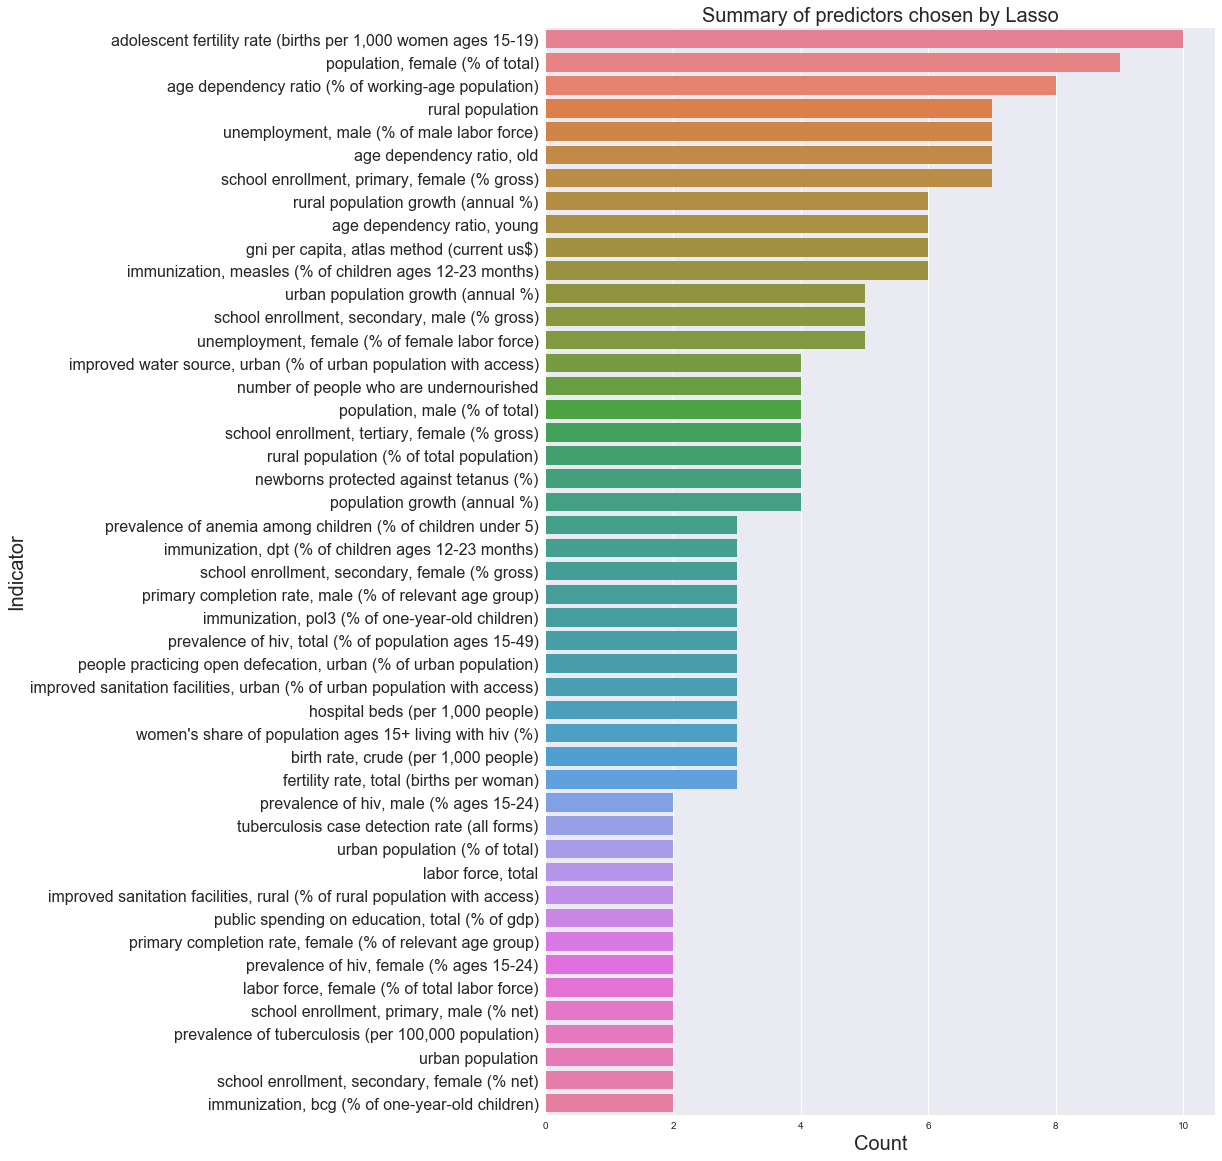

In [37]:
plt.show()

### Write the model information to csv files

In [38]:
# write the scores from each of the models for each country combination to a csv file
all_summary_models.to_csv('./all_summary_models.csv', index=False)

# write the Lasso and LinearRegression coefficients to a csv file
coef_models.to_csv('./coef_models.csv', index=False)

### Write the complete combo data for country combinations to a csv file

In [39]:
# This will retrieve all data for each combo using the combination of indicators chosen as significant by Lasso
# Not all indicators are significant for each combo but Tableau works better when the data is complete

#print(tableau_df.columns)

tableau_indicators = life_expectancy+list(lasso_coefs_df[lasso_coefs_df.Count > 1].Indicator.values)
tableau_df = pd.DataFrame()
for combo in combos_str.split('\n'):
    if (combo != ''):
        print(combo)
        prev_tableau_df = tableau_df.copy()
        y, y_as_float, X, col_names, tableau_df = data_process_nulls(combo, tableau_indicators, True, True)
        tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)

tableau_df.to_csv('./tableau2_df.csv')

Arab World
test_data.shape initial: (50, 44)
test_data.shape after removing unnecessary features and transpose (41, 50)
test_data.shape after dropping columns with more than 20 nulls (41, 45)
test_data.shape after dropping life_expectancy and target nulls (40, 42)

Caribbean small states
test_data.shape initial: (50, 44)
test_data.shape after removing unnecessary features and transpose (41, 50)
test_data.shape after dropping columns with more than 20 nulls (41, 45)
test_data.shape after dropping life_expectancy and target nulls (40, 42)

Central Europe and the Baltics
test_data.shape initial: (50, 44)
test_data.shape after removing unnecessary features and transpose (41, 50)
test_data.shape after dropping columns with more than 20 nulls (41, 37)
test_data.shape after dropping life_expectancy and target nulls (40, 34)

East Asia & Pacific
test_data.shape initial: (50, 44)
test_data.shape after removing unnecessary features and transpose (41, 50)
test_data.shape after dropping columns wi

In [40]:
# Store the limited combo data in a csv file for Tableau - not being used
# Note this data has holes in it as it only has values for the indicators chosen as significant by Lasso
# The set of indicators will be different for each combo although there is some degree of commonality

#temp_cols = list(tableau_df.columns[2:])
#temp_cols.remove(y_indicator)
#temp_cols = ['Combo', 'Year'] + [y_indicator] + temp_cols
#tableau_df = tableau_df[temp_cols]
#tableau_df.to_csv('./tableau2_df.csv', index=False)

In [41]:
### Check nulls ###
# Comment out 2 lines in data_process_nulls if using this cell 
#tableau_df = pd.DataFrame()
#for combo in combos_str.split('\n'):
#    if (combo != ''):
#        print(combo)
#        prev_tableau_df = tableau_df.copy()
#        y, y_as_float, X, col_names, tableau_df = data_process_nulls(combo, list(lasso_coefs_df.Indicator) + life_expectancy, use_median=False, tableau=True)
#        tableau_df = pd.concat([prev_tableau_df, tableau_df], axis=0, ignore_index=True)

#tableau_df.to_csv('./test_data_nulls.csv', index=False)

## Combine models evaluation
All combinations of models when passed to VotingClassifier give the same error:
** "ValueError: Can't handle mix of multiclass and continuous" **

In [42]:
# ValueError: Can't handle mix of multiclass and continuous

#from sklearn.ensemble import VotingClassifier
#np.random.seed(98765)
#eclf = VotingClassifier(estimators=[('SupportVectorRegression', svr), ('KNeighborsRegressor', knr), \
#                                    ('LinearRegression', linr), ('LogisticRegression', logr)], \
#                                    voting='hard')
#eclf = VotingClassifier(estimators=[('SupportVectorRegression', svr), ('KNeighborsRegressor', knr)], \
#                                    voting='soft')
#for clf, label in zip([svr, knr, linr, logr], \
#    ['SupportVectorRegression', 'KNeighborsRegressor', 'LinearRegression', 'LogisticRegression']):
#for clf, label in zip([svr, knr], \
    #['SupportVectorRegression', 'KNeighborsRegressor']):
    #scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    #print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    #model_test(X_train, y_train, X_test, y_test, X, y, label, clf, summary_models)

### Optional Plotting

In [43]:
# do a box plot
#plt.rcParams["figure.figsize"] = [16, 12]
#tableau_df_box = tableau_df['adolescent fertility rate (births per 1,000 women ages 15-19)'].copy()
#tableau_df_box.drop(y_indicator, axis=1, inplace=True)
#tableau_df_box.dropna(axis=1, inplace=True)
#tableau_df_box.plot.box(rot=90)
#plt.show()
#print(tableau_df.columns)

In [44]:
#try some pair plots, can't do it where there are too many indicators as the graphs are too small
#y2, y_as_float2, X2, columns = data_process_nulls('Fragile and conflict affected situations', list(lasso_coefs.variable.head(8)) + life_expectancy)
#test_data = pd.DataFrame(X2)
#test_data
#sns.pairplot(test_data)#, vars=[0, 1, 2])
#plt.show()

### Close the SQL connection

In [45]:
connection.close()